<a href="https://colab.research.google.com/github/surpha/mVQA/blob/main/BLIP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chat with BLIP-2

In this notebook, we'll illustrate usage of BLIP-2, a state-of-the-art vision-language model by Salesforce.

HuggingFace docs: https://huggingface.co/docs/transformers/main/en/model_doc/blip_2.

## Set-up environment

We'll start by installing 🤗 Transformers. As the model is brand new at the time of writing this notebook, we install it from source.

Note that it's advised to run this notebook on a GPU environment, high RAM.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 3.4 MB/s eta 0:00:00


## Load image

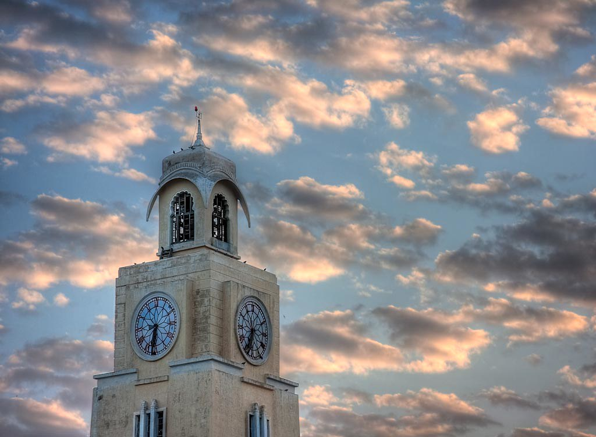

In [ ]:
import requests
from PIL import Image

url = 'https://live.staticflickr.com/3613/3425642282_552cc4842e_b.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
display(image.resize((596, 437)))

## Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's use the GPU, as it will make generation a lot faster.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

## Image captioning

If you don't provide any text prompt, then the model will by default start generating text from the BOS (beginning-of-sequence) token. So it will generate a caption for the image.

In [ ]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a clock tower with a clock on it


## Prompted image captioning

You can provide a text prompt, which the model will continue given the image.

In [ ]:
prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a clock tower


In [ ]:
prompt = "the weather looks"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


like it is going to be cloudy


## Visual question answering (VQA)

In [ ]:
prompt = "Question: which city is this? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


it's a city in the middle east


## Chat-based prompting

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "which city is this?"), the model generates an answer for it "Singapore"), which we just concatenate to the conversation. Then we ask a follow-up question ("why?") which we also just concatenate and feed to the model.

This means that the context can't be too long - models like OPT and T5 (the language models being used in BLIP-2) have a context length of 512 tokens.

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


merlion is a type of fish.


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.1 MB/s 

In [ ]:
import gradio as gr
import requests
from PIL import Image
import io
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration

def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Process the image and question
    inputs = processor(image, text=question_prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Create Gradio interface
image_url_input = gr.Textbox(label="Image URL")
question_input = gr.Textbox(label="Question")
output_text = gr.Textbox(label="Answer")

gr.Interface(fn=get_answer,
             inputs=[image_url_input, question_input],
             outputs=output_text,
             title="Image Question Answering",
             description="Enter an image URL and a question to get the answer.",
             allow_flagging=False).launch()

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:382: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3148aba04b568408f8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import requests
from PIL import Image
import io
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration

# Initialize the pre-trained model and processor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Process the image and question
    inputs = processor(image, text=question_prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Create Gradio interface
image_url_input = gr.inputs.Textbox(label="Image URL")
question_input = gr.inputs.Textbox(label="Question")
output_text = gr.outputs.Textbox(label="Answer")

gr.Interface(fn=get_answer,
             inputs=[image_url_input, question_input],
             outputs=output_text,
             title="Image Question Answering",
             description="Enter an image URL and a question to get the answer.",
             allow_flagging=False).launch()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 15704 has 14.73 GiB memory in use. Of the allocated memory 14.10 GiB is allocated by PyTorch, and 497.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Construct the prompt with the user's question
    prompt = f"Question: {question_prompt} Answer:"

    # Process the image and question
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Input image URL
image_url = input("Enter the image URL: ")

# Input question
question_prompt = input("Enter your question: ")

# Get the answer
answer = get_answer(image_url, question_prompt)
print("Answer:", answer)

Enter the image URL: https://s3.envato.com/files/248554394/890947.jpg
Enter your question: What is the colour of the ball?


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA__native_layer_norm)

In [ ]:
import requests
from PIL import Image
import io
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration

# Initialize the pre-trained model and processor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure the device is set correctly

def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Move image and model to the same device
    image = image.to(device)

    # Construct the prompt with the user's question
    prompt = f"Question: {question_prompt} Answer:"

    # Process the image and question
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Input image URL
image_url = input("Enter the image URL: ")

# Input question
question_prompt = input("Enter your question: ")

# Get the answer
answer = get_answer(image_url, question_prompt)
print("Answer:", answer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Enter the image URL: https://s3.envato.com/files/248554394/890947.jpg
Enter your question: What is the colour of the boy's shorts?


AttributeError: to

In [ ]:
def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Construct the prompt with the user's question
    prompt = f"Question: {question_prompt} Answer:"

    # Process the image and question
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Input image URL
image_url = input("Enter the image URL: ")

# Input question
question_prompt = input("Enter your question: ")

# Get the answer
answer = get_answer(image_url, question_prompt)
print("Answer:", answer)

Enter the image URL: https://s3.envato.com/files/248554394/890947.jpg
Enter your question: What is the color of the shorts?


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.HalfTensor) should be the same

In [ ]:
def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Move model to the same device as the image
    model.to(device)

    # Construct the prompt with the user's question
    prompt = f"Question: {question_prompt} Answer:"

    # Process the image and question
    inputs = processor(image, text=prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Input image URL
image_url = input("Enter the image URL: ")

# Input question
question_prompt = input("Enter your question: ")

# Get the answer
answer = get_answer(image_url, question_prompt)
print("Answer:", answer)

Enter the image URL: https://s3.envato.com/files/248554394/890947.jpg
Enter your question: What is the color of the shorts?


Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Answer: blue - stock photo - images


In [ ]:
def get_answer(image_url, question_prompt):
    # Download the image from the URL
    image_data = requests.get(image_url, stream=True).content
    image = Image.open(io.BytesIO(image_data))

    # Move model to the same device as the image
    model.to(device)

    # Construct the prompt with the user's question
    prompt = f"Question: {question_prompt} Answer:"

    # Process the image and question
    inputs = processor(image, text=prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return generated_text

# Input image URL
image_url = input("Enter the image URL: ")

# Input question
question_prompt = input("Enter your question: ")

# Get the answer
answer = get_answer(image_url, question_prompt)
print("Answer:", answer)

Enter the image URL: https://live.staticflickr.com/3613/3425642282_552cc4842e_b.jpg
Enter your question: What is in the picture?


Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Answer: The clock tower of the university of alabama
